In [14]:
from google.colab import drive
drive.mount('/content/drive')
! pip install configargparse
! pip install wandb
! pip install open3d
! pip install lpips

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import torch

import open3d as o3d
import os

import sys
#sys.path.append('../')
sys.path.append('drive/Othercomputers/MacBookPro/')
import Rendering.visualization as v
import utils.data as data


In [16]:
def visualize_dataset(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = data.NeRFDataset(args)
    
    '''mesh = o3d.io.read_triangle_mesh(args.mesh, print_progress=True)
    mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(mesh)'''
    dataset.switch_2_xnv_dataset()

    #for subdataset in dataset.subdatasets:
    for subdataset in [d for d in dataset.subdatasets if d.name == "val"]:
        imgfiles = [os.path.join(args.dataset_path, subdataset.name, f) for f in sorted(os.listdir(os.path.join(args.dataset_path, subdataset.name))) if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]

        for i in range(subdataset.n_images):
            xnv, img, depths = dataset.get_X_target(subdataset.name, i, device=device)
            v.dataset_view_rgb_xnv(img.detach().cpu(), 
                                    (dataset.hwf[0], dataset.hwf[1], 3), 
                                    xnv[..., :3].detach().cpu(), 
                                    xnv[..., 3:6].detach().cpu(), 
                                    xnv[..., 6:].detach().cpu())

In [17]:
class Args:
    def __init__(self):
        self.mesh_path = "drive/Othercomputers/MacBookPro/lego/meshed-poisson.ply" #"../data/lego_llff/meshed-delaunay.ply"
        self.dataset_path = "drive/Othercomputers/MacBookPro/lego" #"../data/lego_llff"
        self.dataset_type = "llff"
        self.factor = 1
        self.batch_size = 8192
        self.shuffle = True
        self.test = True
        self.dataset_to_gpu = False
        self.train_images=0
        self.val_images = 20
        self.test_images= 0

visualize_dataset(Args())


Output hidden; open in https://colab.research.google.com to view.

In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def crop_image(path, saveas):
    img = cv2.imread(path)
    #img = np.concatenate((np.zeros((32, 500, 3), dtype=np.uint8)*255, img[:,150:650,:], np.zeros((32, 500, 3), dtype=np.uint8)*255))
    
    img = cv2.cvtColor(img[25:225, 350:550], cv2.COLOR_BGR2RGB)
    im = Image.fromarray(img)
    im.save(saveas)
    plt.imshow(im)
    plt.show()
    
'''def crop_image(path, saveas):
    im = Image.open(path)
    im = np.array(im)
    #img = np.concatenate((np.zeros((32, 500, 3), dtype=np.uint8)*255, img[:,150:650,:], np.zeros((32, 500, 3), dtype=np.uint8)*255))
    
    #img = cv2.cvtColor(img[240:475, 275:510], cv2.COLOR_BGR2RGB)
    im = Image.fromarray(im[250:550, 250:550])
    im.save(saveas)
    plt.imshow(im)
    plt.show()'''

'def crop_image(path, saveas):\n    im = Image.open(path)\n    im = np.array(im)\n    #img = np.concatenate((np.zeros((32, 500, 3), dtype=np.uint8)*255, img[:,150:650,:], np.zeros((32, 500, 3), dtype=np.uint8)*255))\n    \n    #img = cv2.cvtColor(img[240:475, 275:510], cv2.COLOR_BGR2RGB)\n    im = Image.fromarray(im[250:550, 250:550])\n    im.save(saveas)\n    plt.imshow(im)\n    plt.show()'

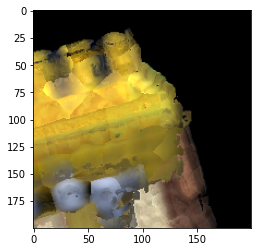

"crop_image(f'../Rendering/out/reflectance_drums_light_sphharm/-1degrees/val_reflectance_1_diffuse_it512.png',\n        '../../Thesis/Images/drums_nospharm_diffuse_crop.png')"

In [29]:
#for i in [8, 64, 125, 512]: 
#for img in ["specular", "diffuse", "reflectance"]:
'''crop_image(f'../Rendering/out/clusterised_radiance_drums/6freqs/val_xnv_pred_it64.png',
        f'../../Thesis/Images/drums_6freqs_precise_crop_64.png')'''

crop_image(f'../Rendering/out/clusterised_radiance_lego/6freqs/val_xnv_pred_it512.png',
        f'../../Thesis/Presentation/lego_clusterised_zoom.png')

'''crop_image(f'../data/drums/val/r_100.png',
        f'../../Thesis/Images/drums_target_crop.png')'''

'''crop_image(f'../Rendering/out/reflectance_drums_light_sphharm/-1degrees/val_reflectance_1_diffuse_it512.png',
        '../../Thesis/Images/drums_nospharm_diffuse_crop.png')'''

In [21]:
import json
import seaborn as sns
import pandas as pd

def data_posenc_sphharm():
    data = {
        "PSNR": [],
        "SSIM": [],
        "LPIPS": [],
        "Scene": [],
        "Encoding": [],
        "Num. Clusters": []
    }
    for scene in ["drums", "microphone", "lego"]:
        path_posenc = f"../Rendering/out/reflectance_{scene}_light_posenc_XH"
        path_sphharm = f"../Rendering/out/reflectance_{scene}_light_sphharm/"
        
        for path, method in zip([path_posenc, path_sphharm], ["Pos. Enc.", "SH"]):
            for num_clusters in [8, 64, 125, 512]:
                with open(f"{path}/val_results_{num_clusters}clusters.json", "r") as json_file:
                    json_data = json.load(json_file)
                    data["PSNR"].append(json_data["psnr_mean"])
                    data["SSIM"].append(json_data["ssim_mean"])
                    data["LPIPS"].append(json_data["lpips_mean"])
                    data["Scene"].append(scene)
                    data["Num. Clusters"].append(num_clusters)
                    data["Encoding"].append(method)

    return pd.DataFrame(data=data)

posenc_sphharm_df = data_posenc_sphharm()

In [23]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False
})

sns.set_theme(style="whitegrid")

fig=plt.figure(figsize=(3.3,2.2))
plt.ylim(0, 28)
gfg = sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="PSNR", hue="Scene", style="Encoding")
gfg.get_legend().remove()
ax2 = gfg.twinx()
ax2.set_ylim(0,1)
ax2 = sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="LPIPS", hue="Scene", style="Encoding", ax=ax2)
ax2.get_legend().remove()
fig.tight_layout(pad=.5)
plt.savefig("PSNR_LPIPS_SH_posenc.pgf")

fig=plt.figure(figsize=(2.5,2.2))
plt.ylim(0, 1)
gfg = sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="SSIM", hue="Scene", style="Encoding")
fig.tight_layout(pad=.5)
gfg.legend(fontsize=7)
plt.savefig("SSIM_SH_posenc.pgf")

In [46]:
import imageio
from PIL import Image
frames = []

for i in range(200):
    im = Image.open(f'../Rendering/out/reflectance_drums_light/test/reflectance/pred_{i}.png')
    frames.append(im)

f = '../Rendering/out/reflectance_drums_light/test/reflectance/video.mp4'
imageio.mimwrite(f, frames, fps=12)

from IPython.display import Video
Video(f, height=320)

In [30]:
"""
N clusters.
Attention for each cluster.

When attention is applied we squeeze the N clusters info into a single value.

So weights should be a N vector. We need weights for each 3D point. Thats 800x800 weights per image.

When applying the weights we are combining each of 3D colour from each cluster.
weights             ---\ 
                            w0 * c0 + ... + w_nclusters * c_nclusters
cluster predictions ---/

for r in img
    for c in img
        weights = self attention
        w
"""

import torch
n_clusters = 5
weights = torch.arange(0, 20).reshape((4, n_clusters))
img = torch.arange(0, 60).reshape((4, n_clusters, 3))

print(weights)
print(img)
result = torch.diagonal(weights@img)
print(result.shape)
result2 = weights[..., None]*img
print(result2.shape)


for c, channel in zip(range(img.shape[2]), ["red", "green", "blue"]):
    print(img[:,:,c])
    print("result")
    print(result[c])
    print(result2[c])

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11],
         [12, 13, 14]],

        [[15, 16, 17],
         [18, 19, 20],
         [21, 22, 23],
         [24, 25, 26],
         [27, 28, 29]],

        [[30, 31, 32],
         [33, 34, 35],
         [36, 37, 38],
         [39, 40, 41],
         [42, 43, 44]],

        [[45, 46, 47],
         [48, 49, 50],
         [51, 52, 53],
         [54, 55, 56],
         [57, 58, 59]]])
torch.Size([3, 4])
torch.Size([4, 5, 3])
tensor([[ 0,  3,  6,  9, 12],
        [15, 18, 21, 24, 27],
        [30, 33, 36, 39, 42],
        [45, 48, 51, 54, 57]])
result
tensor([  90,  765, 2190, 4365])
tensor([[ 0,  0,  0],
        [ 3,  4,  5],
        [12, 14, 16],
        [27, 30, 33],
        [48, 52, 56]])
tensor([[ 1,  4,  7, 10, 13],
        [16, 19, 22, 25, 28],
        [31, 34, 37, 40, 43],
        

'fig=plt.figure(figsize=(2.5,2.2))\nplt.ylim(0, 1)\ngfg = sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="SSIM", hue="Scene", style="Encoding")\nfig.tight_layout(pad=.5)\ngfg.legend(fontsize=7)\nplt.savefig("SSIM_SH_posenc.pgf")'

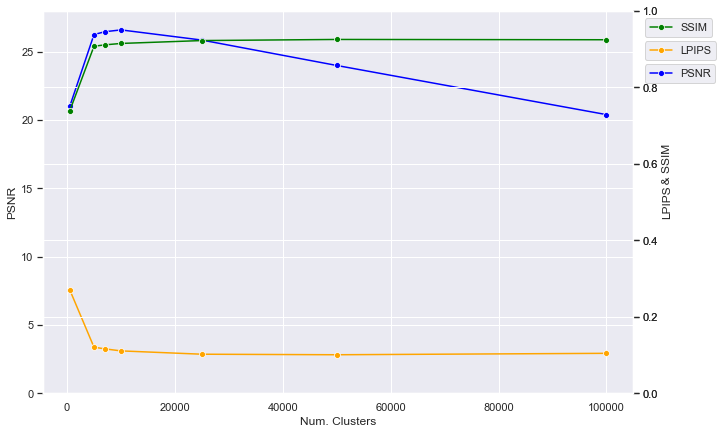

In [20]:
import json
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

def data_posenc_sphharm():
    data = {
        "PSNR": [],
        "                       & SSIM": [],
        "LPIPS": [],
        "Num. Clusters": []
    }
    path = f"../Rendering/out/reflectance_drums_light_sphharm/interpolation_5nn"
    for num_clusters in [512, 5000, 7000, 10_000, 25_000]:
        with open(f"{path}/val_results_{num_clusters}clusters.json", "r") as json_file:
            json_data = json.load(json_file)
            data["PSNR"].append(json_data["psnr_mean"])
            data["                       & SSIM"].append(json_data["ssim_mean"])
            data["LPIPS"].append(json_data["lpips_mean"])
            data["Num. Clusters"].append(num_clusters)

    return pd.DataFrame(data=data)

posenc_sphharm_df = data_posenc_sphharm()

sns.set_theme(style="darkgrid")

fig=plt.figure(figsize=(10, 6))
plt.ylim(0, 28)
gfg = sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="PSNR", label="PSNR", color='blue', marker='o')
plt.legend(bbox_to_anchor=(1.02, 0.86), loc='upper left', borderaxespad=0)
#gfg.get_legend().remove()
ax2 = gfg.twinx()
ax2.set_ylim(0,1)
sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="LPIPS", ax=ax2, label="LPIPS", color='orange', marker='o')
plt.legend(bbox_to_anchor=(1.02, 0.92), loc='upper left', borderaxespad=0)
ax3 = gfg.twinx()
ax3.set_ylim(0,1)
sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="                       & SSIM", ax=ax3, label="SSIM", color='green', marker='o')
#ax2.get_legend().remove()
fig.tight_layout(pad=.5)
plt.legend(bbox_to_anchor=(1.02, 0.98), loc='upper left', borderaxespad=0)
plt.savefig(f"../Rendering/out/reflectance_drums_light_sphharm/num_clusters_quality.png", dpi=300)

'''fig=plt.figure(figsize=(2.5,2.2))
plt.ylim(0, 1)
gfg = sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="SSIM", hue="Scene", style="Encoding")
fig.tight_layout(pad=.5)
gfg.legend(fontsize=7)
plt.savefig("SSIM_SH_posenc.pgf")'''

In [30]:
import json
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

def data_posenc_sphharm():
    data = {
        "PSNR": [],
        "SSIM": [],
        "LPIPS": [],
        "Num. Clusters": []
    }
    path = f"../Rendering/out/reflectance_drums_light_sphharm/interpolation_5nn"
    for num_clusters in [512, 5000, 7000, 10_000, 25_000]:
        with open(f"{path}/val_results_{num_clusters}clusters.json", "r") as json_file:
            json_data = json.load(json_file)
            data["PSNR"].append(json_data["psnr_mean"])
            data["SSIM"].append(json_data["ssim_mean"])
            data["LPIPS"].append(json_data["lpips_mean"])
            data["Num. Clusters"].append(num_clusters)

    return pd.DataFrame(data=data)

posenc_sphharm_df = data_posenc_sphharm()

In [31]:
posenc_sphharm_df

,PSNR,SSIM,LPIPS,Num. Clusters
0,24.355824,0.891780,0.140948,512
1,26.300579,0.912044,0.115007,5000
2,26.495590,0.914971,0.111130,7000
3,26.390737,0.917388,0.107353,10000
4,25.913995,0.921075,0.100897,25000


In [27]:
import scipy.spatial
import torch
from torch_geometric.nn import knn

def self_distances(centroids):
    tree = scipy.spatial.cKDTree(centroids.detach().numpy())
    dist, col = tree.query(centroids.detach().cpu(), k=len(centroids))
    dist = torch.from_numpy(dist).to(centroids.dtype)
    col = torch.from_numpy(col).to(torch.long)
    dist2 = torch.zeros_like(dist)
    row = torch.arange(col.size(0), dtype=torch.long).view(-1, 1).repeat(1, len(centroids))
    col_d = torch.arange(col.size(0), dtype=torch.long).view(1, -1).repeat(1, len(centroids))
    dist2[row.flatten(), col.flatten()] = dist[row.flatten(), col_d.flatten()]
    return dist2, tree

def k_dist(centroids, y, k, selfdistances, tree):
    dist, col = tree.query(y.detach().cpu(), k=k)
    dist = torch.from_numpy(dist).to(centroids.dtype)
    col = torch.from_numpy(col).to(torch.long)

    return col, dist

centroids = torch.Tensor([[1, 1, 1], [3,2,0], [5,2,3], [2, 4, 5], [4,2,3]])
batch_x = torch.tensor([0, 0, 0, 0])
y = torch.Tensor([[3, 5, 0], [2,1,1], [5,2,4], [2,4,2]])
batch_y = torch.tensor([0, 0])
k = 3
nearest = knn(centroids, y, k)
row = nearest[0].reshape(-1, k)
cluster_ids = nearest[1].reshape(-1, k)

dist = (y-centroids[cluster_ids.T]).pow(2).sum(2).sqrt()
suma = dist.sum(0)
weights = torch.exp(-dist)
print(weights)
weights = torch.nn.functional.softmax(weights, dim=0)
print(weights)


tensor([[0.0498, 0.3679, 0.3679, 0.0498],
        [0.0128, 0.1769, 0.2431, 0.0498],
        [0.0102, 0.0498, 0.0237, 0.0498]])
tensor([[0.3419, 0.3916, 0.3859, 0.3333],
        [0.3295, 0.3235, 0.3406, 0.3333],
        [0.3286, 0.2849, 0.2735, 0.3333]])


In [125]:
import numpy as np
img = np.random.normal(size=(256,256))
x = np.linspace(0, 255, 256, dtype=int)
xv, yv, zv = np.meshgrid(x, x, x)
print("xs:")
print(xv)
print("ys:")
print(yv)

'''print("original img")
print(img)
print("\nindexed img")'''

a, b, c, d = 0.1, 0.2, 0.3, 0.4
multiplier = a**2 + b**2 + c**2 #igual que abans ferho per cada pla
xf, yf, zf = xv.flatten(), yv.flatten(), zv.flatten()
result = d - a * xf - b * yf - c * zf # aixo hauria de ser un vector on cada fila hauria de ser el 'result' que tens ara per cada iteració
result = result.reshape(len(result), 1)
t = result/multiplier # again un vector on cada fila hauria de ser la 't' que tens ara per cada iteració
voxel_original = np.stack((xf, yf, zf), axis=1)
plane = np.tile(np.array([a, b, c]), (len(voxel_original), 1))
voxel_flipped = voxel_original + 2 * t * plane


'''print(img[yv.flatten(), xv.flatten()].reshape((256, 256)))
print("\nflipped img")
print(img[(255-yv).flatten(), xv.flatten()].reshape((256, 256)))'''



xs:
[[[  0   0   0 ...   0   0   0]
  [  1   1   1 ...   1   1   1]
  [  2   2   2 ...   2   2   2]
  ...
  [253 253 253 ... 253 253 253]
  [254 254 254 ... 254 254 254]
  [255 255 255 ... 255 255 255]]

 [[  0   0   0 ...   0   0   0]
  [  1   1   1 ...   1   1   1]
  [  2   2   2 ...   2   2   2]
  ...
  [253 253 253 ... 253 253 253]
  [254 254 254 ... 254 254 254]
  [255 255 255 ... 255 255 255]]

 [[  0   0   0 ...   0   0   0]
  [  1   1   1 ...   1   1   1]
  [  2   2   2 ...   2   2   2]
  ...
  [253 253 253 ... 253 253 253]
  [254 254 254 ... 254 254 254]
  [255 255 255 ... 255 255 255]]

 ...

 [[  0   0   0 ...   0   0   0]
  [  1   1   1 ...   1   1   1]
  [  2   2   2 ...   2   2   2]
  ...
  [253 253 253 ... 253 253 253]
  [254 254 254 ... 254 254 254]
  [255 255 255 ... 255 255 255]]

 [[  0   0   0 ...   0   0   0]
  [  1   1   1 ...   1   1   1]
  [  2   2   2 ...   2   2   2]
  ...
  [253 253 253 ... 253 253 253]
  [254 254 254 ... 254 254 254]
  [255 255 255 ... 255 2

'print(img[yv.flatten(), xv.flatten()].reshape((256, 256)))\nprint("\nflipped img")\nprint(img[(255-yv).flatten(), xv.flatten()].reshape((256, 256)))'

In [28]:
import torch

values = torch.arange(23)
print(values[torch.tensor([0,2,4,2,5,2,3,4,5,2,1])])

tensor([0, 2, 4, 2, 5, 2, 3, 4, 5, 2, 1])
